# refs

[global average pooling vs max pooling](https://stats.stackexchange.com/questions/257321/what-is-global-max-pooling-layer-and-what-is-its-advantage-over-maxpooling-layer)

[pre trained vgg 1](https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98)

[pre trained vgg 2](https://www.kaggle.com/chmaxx/finetune-vgg16-0-97-with-minimal-effort)

[ensembles](http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/)

[other model types](http://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3882984177126620798, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 361496576
 locality {
   bus_id: 1
 }
 incarnation: 14271453165574102131
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:04:00.0"]

# setup

In [13]:
import h5py
import numpy as np
import PIL

from keras import backend as K
from keras.preprocessing import image

from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [14]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
W_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(CUR_DIR, DATA_DIR)

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


# make the model 

In [62]:
base_model = VGG16(weights='imagenet', include_top=False)

In [63]:
for layer in base_model.layers:
    layer.trainable = False
    
top_model = base_model.get_layer('block5_conv3').output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [64]:
batch_size = 5

img_width = 600
img_height = 450

gen = image.ImageDataGenerator()
va_gen = image.ImageDataGenerator(rescale=1., featurewise_center=True)
gen_t = image.ImageDataGenerator(rescale=1., 
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="reflect")

# original vgg means [103.939, 116.779, 123.68]
# my mean is [111.32052594, 121.25063492, 103.65633209]
# you need ot subtract the vgg mean because thats
# what vgg was trained on, its weights are tried to that
# nromalization (they did not use batch norm)
# wha you see below is the mean for the 
gen.mean = np.array([103.939, 116.779, 123.68]).reshape(1,1,3)
va_gen.mean = np.array([103.939, 116.779, 123.68]).reshape(1,1,3)
gen_t.mean = np.array([103.939, 116.779, 123.68]).reshape(1,1,3)

te_batches = gen.flow_from_directory(test_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 1531 images belonging to 1 classes.


In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

img_width = 300
img_height = 225

tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

tr_batches_aug = gen_t.flow_from_directory(train_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = va_gen.flow_from_directory(valid_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

hist = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

img_width = 600
img_height = 450

tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

tr_batches_aug = gen_t.flow_from_directory(train_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = va_gen.flow_from_directory(valid_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

hist2 = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

Found 1836 images belonging to 2 classes.
Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Epoch 1/10
368/368 [==============================] - 75s - loss: 0.3284 - acc: 0.8826 - val_loss: 0.1691 - val_acc: 0.9281
Epoch 2/10
368/368 [==============================] - 73s - loss: 0.2491 - acc: 0.9185 - val_loss: 0.2183 - val_acc: 0.9303
Epoch 3/10
368/368 [==============================] - 73s - loss: 0.2728 - acc: 0.9217 - val_loss: 0.2064 - val_acc: 0.9368
Epoch 4/10
368/368 [==============================] - 73s - loss: 0.2599 - acc: 0.9185 - val_loss: 0.1654 - val_acc: 0.9434
Epoch 5/10
368/368 [==============================] - 73s - loss: 0.2225 - acc: 0.9239 - val_loss: 0.2054 - val_acc: 0.9346
Epoch 6/10
368/368 [==============================] - 73s - loss: 0.2601 - acc: 0.9163 - val_loss: 0.1844 - val_acc: 0.9368
Epoch 7/10
368/368 [==============================] - 73s - loss: 0.2291 - acc: 0.9337 - val_loss: 0.1979 - val_acc: 0.9477
Epoch 8

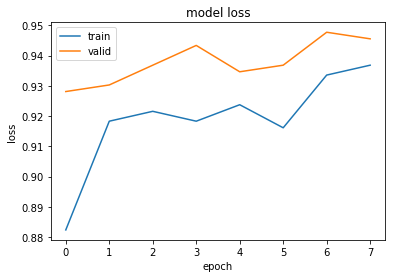

In [66]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

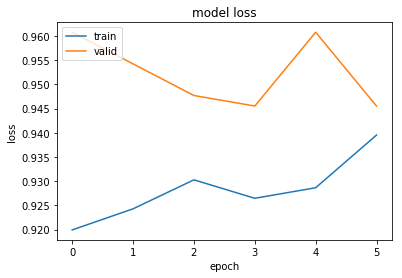

In [67]:
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [68]:
img_width = 800
img_height = 600

tr_batches_aug = gen_t.flow_from_directory(train_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = va_gen.flow_from_directory(valid_path, 
                                     target_size=(img_height,img_width), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

hist3 = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Epoch 1/10
368/368 [==============================] - 474s - loss: 0.2111 - acc: 0.9299 - val_loss: 0.1448 - val_acc: 0.9455
Epoch 2/10
368/368 [==============================] - 465s - loss: 0.1839 - acc: 0.9380 - val_loss: 0.2086 - val_acc: 0.9412
Epoch 3/10
368/368 [==============================] - 465s - loss: 0.1983 - acc: 0.9348 - val_loss: 0.2202 - val_acc: 0.9455
Epoch 4/10
368/368 [==============================] - 466s - loss: 0.1690 - acc: 0.9402 - val_loss: 0.1669 - val_acc: 0.9608
Epoch 5/10
368/368 [==============================] - 466s - loss: 0.2026 - acc: 0.9408 - val_loss: 0.1677 - val_acc: 0.9455
Epoch 00004: early stopping


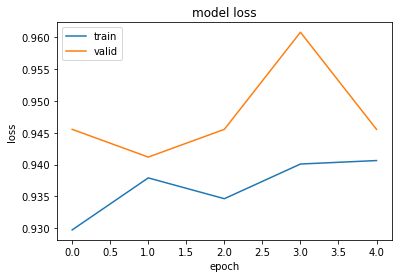

In [69]:
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [70]:
# lets save weights and come back.
model.save_weights(os.path.join(DATA_DIR, 'vgg16_jun9_2017.h5'))

# summary

i changed the iimage generator and the result seems a lot more robust. the first one mentioned here: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

ok its actually just slower to train and less stable on valid accuracy. gets a lower training accuracy which implies that were exposing fewer features to the algo with this image data gen.



# ideas

# so waht did i change?
# i  used the vgg average and not the one i calculated to subtract from pixels
# batch size changed to 5.
# binary class mode is needed to use 1 output node with the sigmoid activation
# imag sizing changed to 600 450
# used rmsprop instaed of adam
# differences between my implementation and the kaggle kernel: i trained on lareg imgs first, then on smaller
# did that make a difference? -> it looks like training on smaller images AFTER bigs ones makse validation accurracy worse
# but this doesntm ean that the other wya around isnt good.
#added dropout on the last layer between the dense and output node
# which of these is superficial or made things worse? which actually made things better
# could we get a better result by adding two layers one with more nodes, then less nodes so it focuses
# could we get a better result by resizing images?
# what abut adding bathcnorm? waht about using a bathcnormed vgg16
# what about psuedo labelling?
# what about resnet? 
# check out this idea: http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/

# maybe we need to remvoe pooling layers? hinton does say theyre kinda shit, repalce with what? -> ok i think we should use a global max pooling layer at the end instaedo f an average pooling layer. average pooling is like saying X YxY conv featurse how doggy of catty is each one on avg. max pooling layer is like saying DID ANY OF THE FEATURES TRIGGER DOG OR CAT (hydrangea or no hydrangea)

# try to use a SELU actvation function: https://arxiv.org/pdf/1706.02515.pdf

# try this:

https://www.kaggle.com/hexietufts/easy-to-use-keras-imagedatagenerator